# Librerías

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, jaccard_score
import warnings
from google.colab import drive

drive.mount('/content/drive')
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
!mkdir /root/tensorflow_datasets
!cp -r /content/drive/MyDrive/tensorflow_dataset/galaxy_zoo3d /root/tensorflow_datasets/

# Complete

In [ ]:
filename = '2022_08_23-13:52:10_only_bar-mask_epochs:150_size:128_th:3_patience:5'

## Parameters

In [ ]:
train_with = filename.split('_')[3].split('-')[0]
mask = filename.split('_')[4].split('-')[0]+'_mask'
size = int(filename.split('_')[6].split(':')[1])
threshold = int(filename.split('_')[7].split(':')[1])
min_vote = 3

# Data

## Useful functions

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (size, size), method="nearest")
    input_mask = tf.image.resize(input_mask, (size, size), method="nearest")

    return input_image, input_mask 


def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
  
    return input_image


def binary_mask(input_mask):
    th = threshold
    input_mask = tf.where(input_mask<th, tf.zeros_like(input_mask), tf.ones_like(input_mask))
    
    return input_mask
    
    
def load_image_train(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    input_image = datapoint['image']
    input_mask = datapoint[mask]
    input_image, input_mask = resize(input_image, input_mask)
    input_image = normalize(input_image)
    input_mask = binary_mask(input_mask)

    return input_image, input_mask


def display(display_list):
  plt.figure(figsize=(15, 15))
  titles = ['Image', 'Mask', 'Prediction']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.title(titles[i])
    plt.axis("off")
  plt.show()

## Data loader

In [ ]:
ds_test = tfds.load('galaxy_zoo3d', split=['train[75%:]'])[0]

if train_with == 'all':
  BATCH_SIZE, VAL_SIZE, TEST_SIZE = 64, 4992, 2461
elif train_with == 'only':
  BATCH_SIZE = 32
  if mask == 'spiral_mask':
    ds_test = ds_test.filter(lambda x: tf.reduce_max(x['spiral_mask']) >= min_vote)
    VAL_SIZE, TEST_SIZE = 1088, 551
  elif mask == 'bar_mask':
    ds_test = ds_test.filter(lambda x: tf.reduce_max(x['bar_mask']) >= min_vote)
    VAL_SIZE, TEST_SIZE = 832, 421

test_dataset = ds_test.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

validation_batches = test_dataset.take(VAL_SIZE).batch(BATCH_SIZE)
test_batches = test_dataset.skip(VAL_SIZE).take(TEST_SIZE).batch(BATCH_SIZE)

# Load

## Learning results

In [ ]:
path = '/content/drive/MyDrive/Galaxy Segmentation Project/Modelos/'
results = pd.read_csv(f'{path}{filename}/{filename}.csv')

## Model

In [ ]:
unet_model = load_model(f'{path}{filename}/{filename}_best.h5')

# Learning curves

## Display function

In [ ]:
def display_learning_curves(results):

    loss = results["loss"]
    val_loss = results["val_loss"]

    acc = results["accuracy"]
    val_acc = results["val_accuracy"]

    epochs_range = range(len(results))

    fig, ax = plt.subplots(1, 2, figsize=(16,7))

    ax[0].plot(epochs_range, loss, label="train loss", linewidth=2.5)
    ax[0].plot(epochs_range, val_loss, label="validation loss", linewidth=2.5)
    ax[0].set_xlabel("Epoch", fontsize=20, labelpad=10)
    ax[0].set_ylabel("Loss", fontsize=20, labelpad=10)
    ax[0].set_ylim(min(min(loss), min(val_loss)), max(max(loss[1:]), max(val_loss[1:])))
    ax[0].tick_params(axis='both', labelsize=15)
    ax[0].legend(loc="best", fontsize=15)

    ax[1].plot(epochs_range, acc, label="train accuracy", linewidth=2.5)
    ax[1].plot(epochs_range, val_acc, label="validation accuracy", linewidth=2.5)
    ax[1].set_xlabel("Epoch", fontsize=20, labelpad=15)
    ax[1].set_ylabel("Accuracy", fontsize=20, labelpad=15)
    ax[1].tick_params(axis='both', labelsize=15)
    ax[1].legend(loc="best", fontsize=15)

    fig.subplots_adjust(wspace=4)
    fig.tight_layout()
    fig.show()

## Graphs

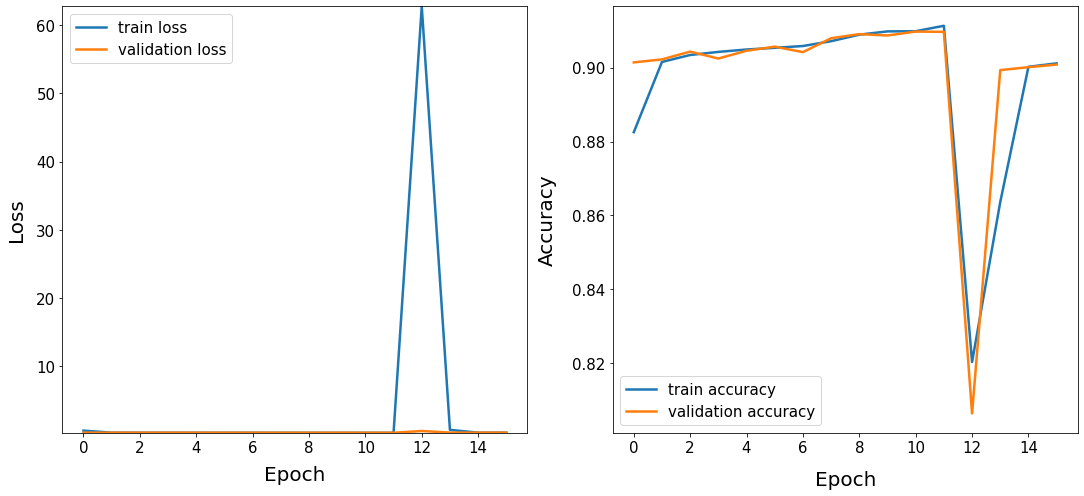

In [ ]:
display_learning_curves(results)

# Predictions

## Prediction functions

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset:
      pred_mask = create_mask(unet_model.predict(image))
      for ind in range(num):
        display([image[ind], mask[ind], pred_mask[ind]])
        if np.amax(pred_mask[ind].numpy()) == 0:
          print(2*'\n')
          continue
        else:
          conf_matrix = confusion_matrix(pred_mask[ind].numpy().reshape(-1), mask[ind].numpy().reshape(-1))
          jacc_score = jaccard_score(pred_mask[ind].numpy().reshape(-1), mask[ind].numpy().reshape(-1))
          print('Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: \n',
          conf_matrix, '\t',
          round(conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]), 2), 2*'\t  ',
          round(conf_matrix[1,1]/(conf_matrix[0,1]+conf_matrix[1,1]), 2), '\t     ',
          round(conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0]), 2), 2*'\t',
          round(jacc_score, 2), '\n')

## Prediction examples

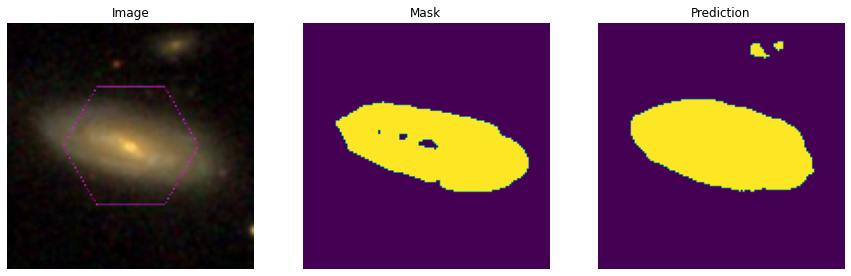

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[12882   141]
 [  476  2885]] 	 0.86 	  	   0.95 	      0.96 		 0.82 



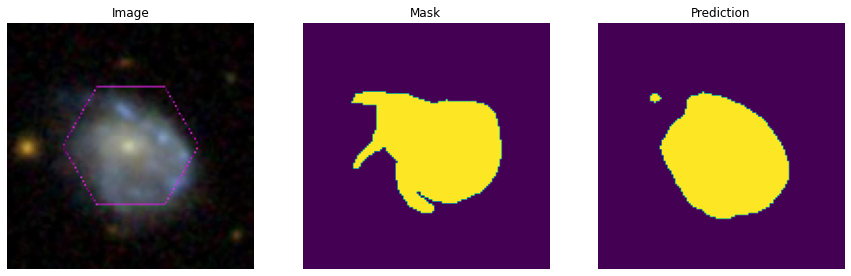

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[12672   595]
 [  532  2585]] 	 0.83 	  	   0.81 	      0.96 		 0.7 



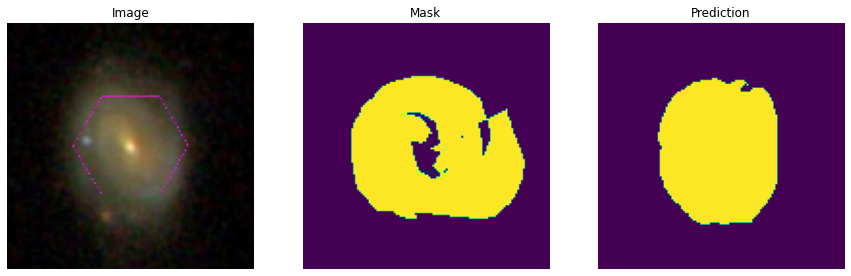

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[11020  1439]
 [  406  3519]] 	 0.9 	  	   0.71 	      0.96 		 0.66 



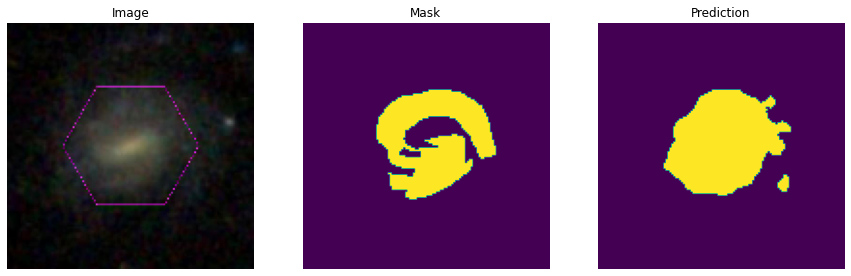

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[13652   269]
 [  696  1767]] 	 0.72 	  	   0.87 	      0.95 		 0.65 



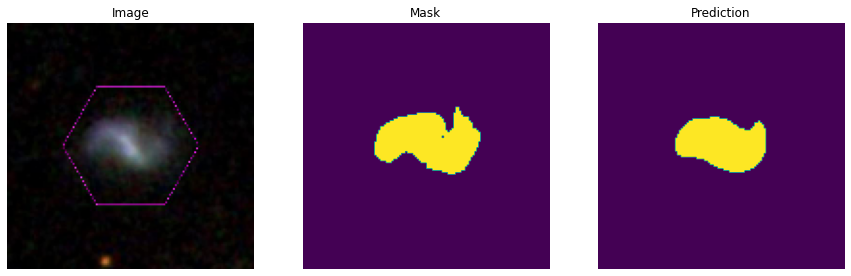

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[15091   287]
 [   54   952]] 	 0.95 	  	   0.77 	      1.0 		 0.74 



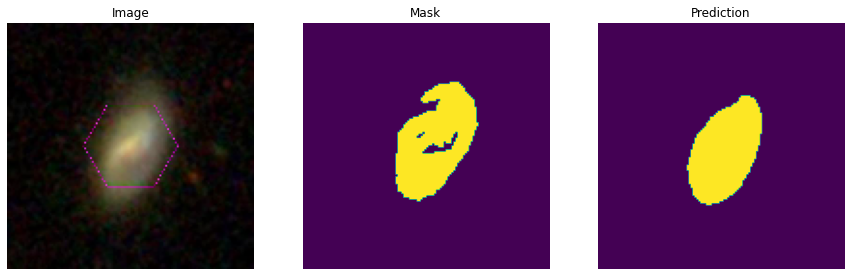

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14556   339]
 [  159  1330]] 	 0.89 	  	   0.8 	      0.99 		 0.73 



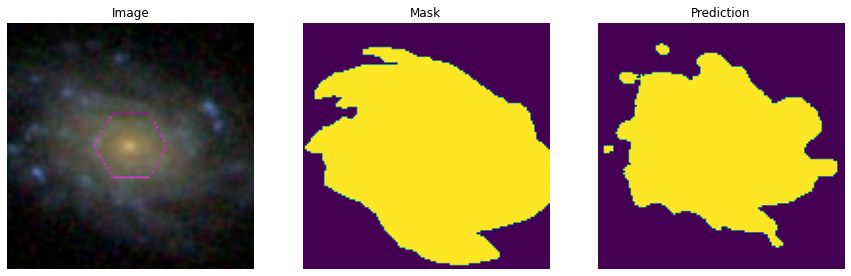

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[6850 2574]
 [ 147 6813]] 	 0.98 	  	   0.73 	      0.98 		 0.71 



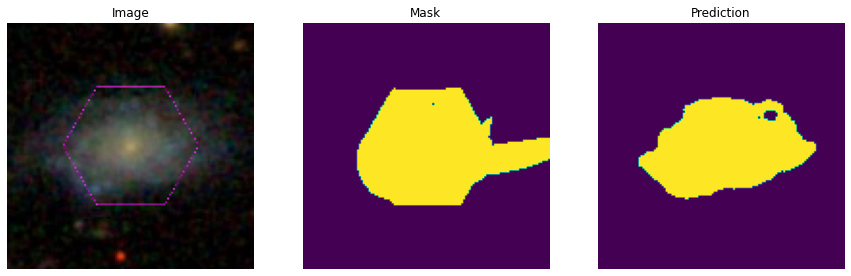

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[12282   917]
 [  231  2954]] 	 0.93 	  	   0.76 	      0.98 		 0.72 



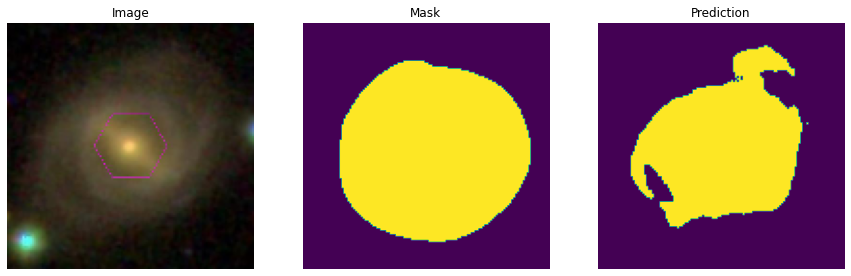

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[8756 2403]
 [ 312 4913]] 	 0.94 	  	   0.67 	      0.97 		 0.64 



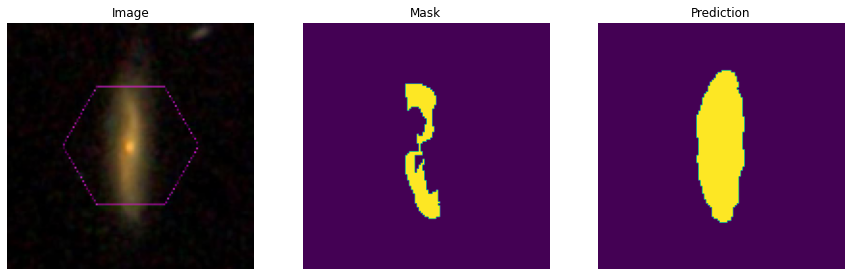

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14832    29]
 [  970   553]] 	 0.36 	  	   0.95 	      0.94 		 0.36 



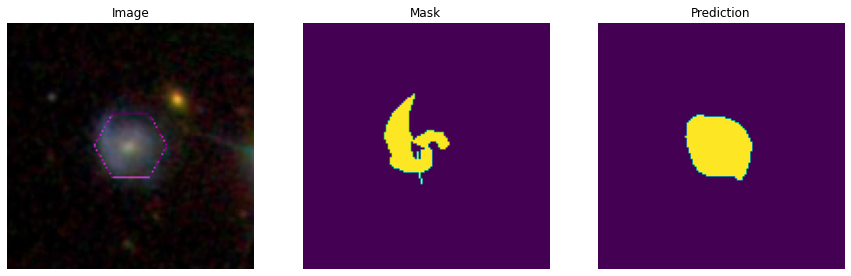

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[15320   153]
 [  435   476]] 	 0.52 	  	   0.76 	      0.97 		 0.45 



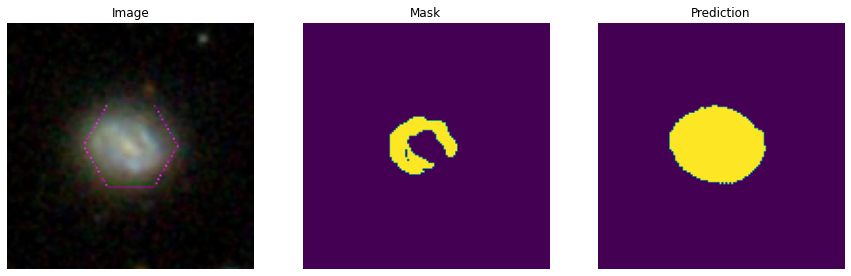

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14868     0]
 [  994   522]] 	 0.34 	  	   1.0 	      0.94 		 0.34 



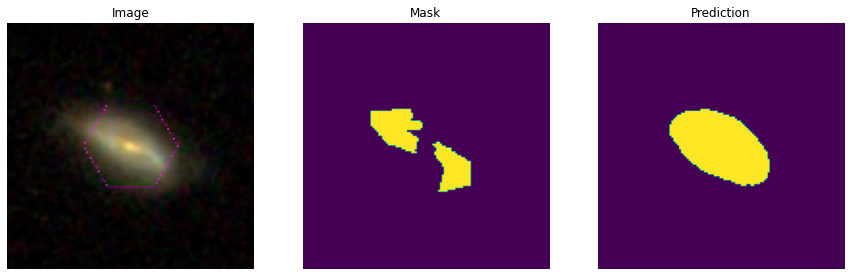

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14903    89]
 [  755   637]] 	 0.46 	  	   0.88 	      0.95 		 0.43 



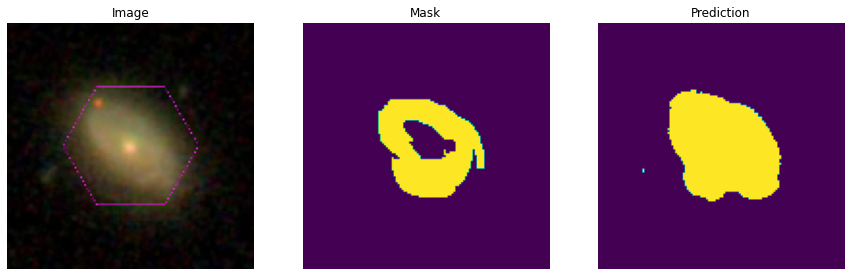

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[13817    33]
 [  836  1698]] 	 0.67 	  	   0.98 	      0.94 		 0.66 



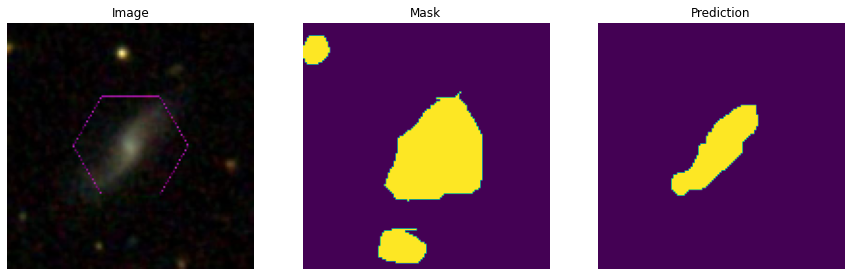

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[13813  1681]
 [   59   831]] 	 0.93 	  	   0.33 	      1.0 		 0.32 



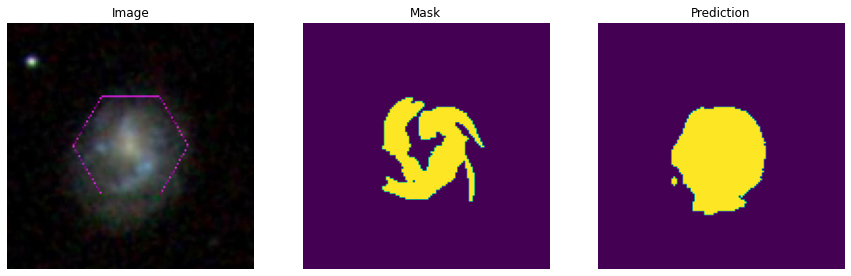

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14042   293]
 [  776  1273]] 	 0.62 	  	   0.81 	      0.95 		 0.54 



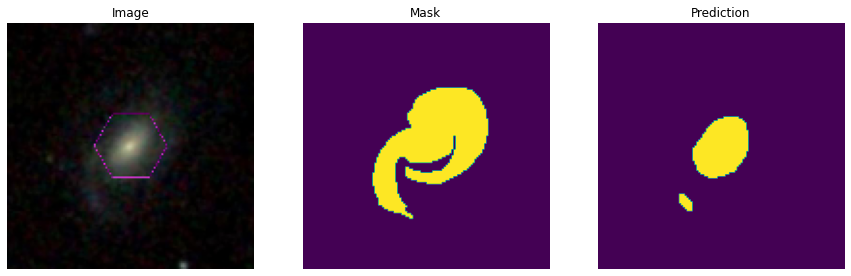

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14142  1500]
 [  124   618]] 	 0.83 	  	   0.29 	      0.99 		 0.28 



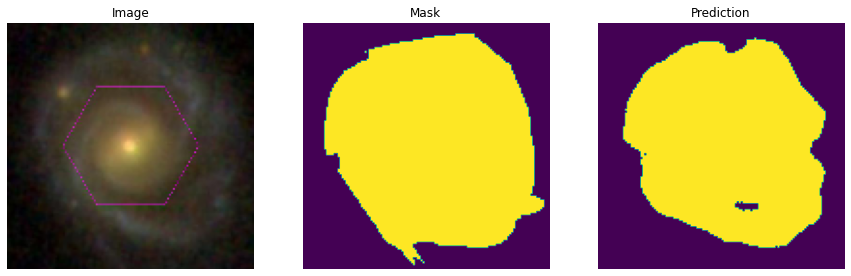

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[6563 1172]
 [  49 8600]] 	 0.99 	  	   0.88 	      0.99 		 0.88 



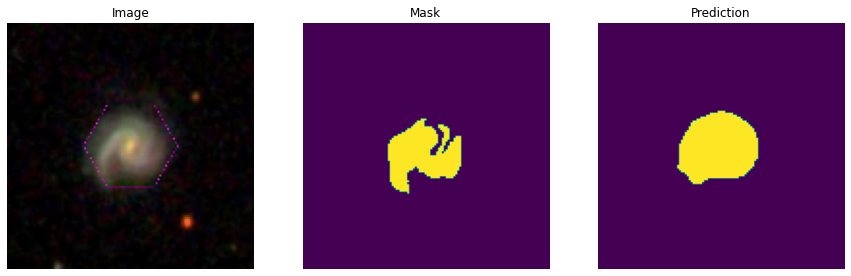

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[15119    59]
 [  369   837]] 	 0.69 	  	   0.93 	      0.98 		 0.66 



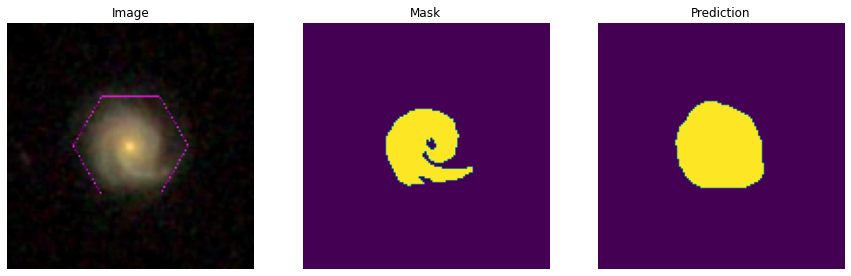

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14726     6]
 [  490  1162]] 	 0.7 	  	   0.99 	      0.97 		 0.7 



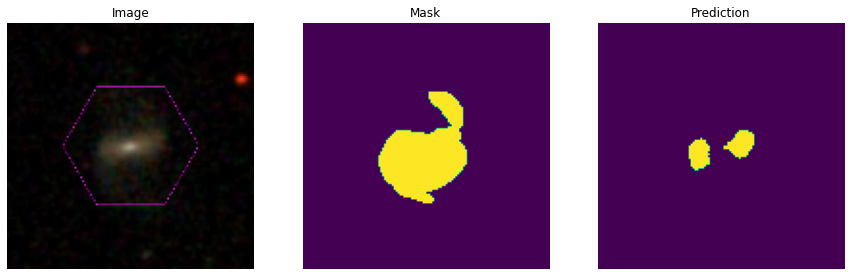

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14876  1215]
 [    0   293]] 	 1.0 	  	   0.19 	      1.0 		 0.19 



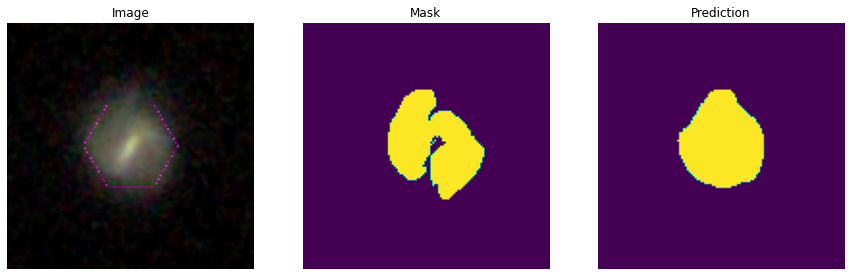

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[14435   304]
 [  232  1413]] 	 0.86 	  	   0.82 	      0.98 		 0.72 



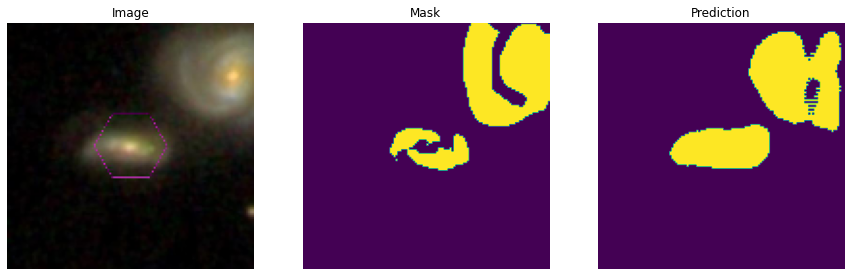

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[13210   455]
 [  838  1881]] 	 0.69 	  	   0.81 	      0.94 		 0.59 



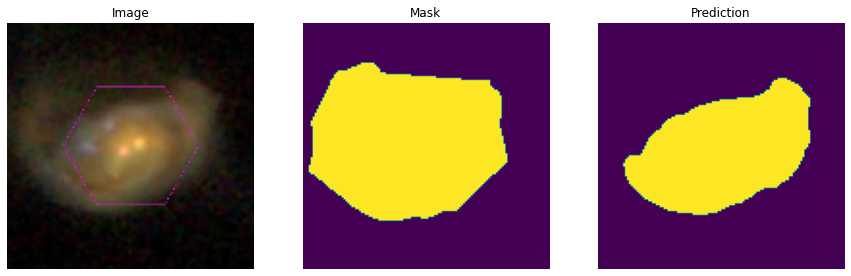

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[9653 2302]
 [ 247 4182]] 	 0.94 	  	   0.64 	      0.98 		 0.62 



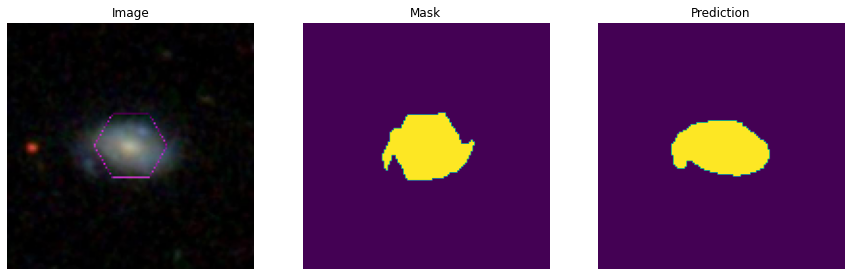

Confusion matrix:     Precision:    Sensitivity/Recall:   Specificity:      Jaccard score: 
 [[15106   162]
 [  141   975]] 	 0.87 	  	   0.86 	      0.99 		 0.76 



In [ ]:
show_predictions(test_batches.skip(random.randint(0, 15)).take(1), 25)